## Description

1. 데이터 분석 목표 : input 784, output 10 손글씨 데이터 다중분류(0~9)

2. auc : 0.9575

3. 기존 코드에서 바꾼 내용
 
 - sklearn의 MNIST데이터 수는 적었음, 많은 데이터를 가지고 자체적으로 train, test를 구분해 가지고 있는 pythorchvision의 MNIST데이터셋을 사용
 
 - model 클래스로 만들어 사용

 - 데이터 정규화 작업

 - ReLU 사용해보기

 - layer 더 추가해보기

 - 자체적으로 가지고 있는 test로 accuracy 측정하기

In [1]:
import numpy as np
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import MNIST

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [4]:
mnist_transform = transforms.Compose([
                                      transforms.ToTensor(), # 이미지 데이터를 텐서로 바꾸기
                                      transforms.Normalize((0.1307, ), (0.3081, )) # 이미지 정규화
])

# 데이터 로드하기
train = MNIST("./data", transform = mnist_transform, train = True, download= True)
test = MNIST("./data", transform = mnist_transform, train = False, download= True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
len(train), len(test)

(60000, 10000)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


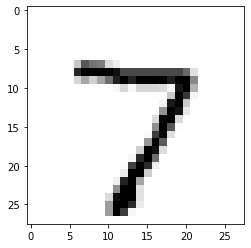

In [28]:
plt.imshow(test.test_data[0:1].view(28,28),cmap="Greys", interpolation = 'nearest')
plt.show()

In [7]:
epochs = 20
batch_size = 100

# drop_lats : 전체 데이터 갯수를 batch_size로 나누면 그 나머지가 하나의 batch를 이루게 되는데 이때 마지막 배치가 과대하게 평가될 수 있음
data_loader = DataLoader(dataset = train, batch_size = batch_size, shuffle = True, drop_last = True)

In [ ]:
# Custom Dataset

"""class CustomDataset(Dataset):
  
  def __init__(self): # 클래스에서 객체가 생성되면 바로 실행되는 함수
    self.x_data = train
    self.y_data = test

  def __len__(self): # 갯수
    return len(self.x_data)

  def __getitem__(self, idx): # iteration 때 마다 해당하는 데이터를 돌려주는 함수
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x, y """

In [9]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(784,256,bias=True),
        nn.ReLU(),
    )
   
    self.layer2 = nn.Sequential(
        nn.Linear(256, 128, bias = True),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(128, 64, bias = True),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Linear(64, 10, bias = True),
        nn.Softmax()
    )

  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [19]:
def init_weights(layer):
  if isinstance(layer, nn.Linear):
    torch.nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)

In [20]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [21]:
loss = nn.CrossEntropyLoss().to(device) # 다중 분류는 crossentropy
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [22]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [24]:
for epoch in range(epochs):
  loss_avg = 0
  total_batch = len(data_loader)

  for x, y in data_loader:
    # x : (100, 784) tensor
    x = x.view(-1, 28*28).to(device)
    y = y.to(device)

    optimizer.zero_grad()
    hypothesis = model(x)
    cost = loss(hypothesis, y)
    cost.backward()
    optimizer.step()

    loss_avg += cost / total_batch

  print("Epoch : ", '%02d' % (epoch + 1), 'cost = ', '{:.9f}'.format(loss_avg))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch :  01 cost =  1.638958097
Epoch :  02 cost =  1.527433872
Epoch :  03 cost =  1.511570096
Epoch :  04 cost =  1.502122521
Epoch :  05 cost =  1.495531678
Epoch :  06 cost =  1.491647363
Epoch :  07 cost =  1.487526536
Epoch :  08 cost =  1.484897614
Epoch :  09 cost =  1.482379556
Epoch :  10 cost =  1.480681777
Epoch :  11 cost =  1.479316115
Epoch :  12 cost =  1.477560163
Epoch :  13 cost =  1.476034045
Epoch :  14 cost =  1.475171566
Epoch :  15 cost =  1.474111795
Epoch :  16 cost =  1.473088741
Epoch :  17 cost =  1.472537279
Epoch :  18 cost =  1.471864700
Epoch :  19 cost =  1.471209168
Epoch :  20 cost =  1.470945835


In [25]:
# Test

with torch.no_grad():
  x_test = test.test_data.view(-1, 28*28).float().to(device)
  y_test = test.test_labels.to(device)

  pred = model(x_test)
  correct = torch.argmax(pred, 1) == y_test
  accuracy = correct.float().mean()
  print("auc : ", accuracy.item())

auc :  0.9575999975204468


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
